In [2]:
import pandas as pd
import numpy as np

import pathlib
import matplotlib.pyplot as plt

from glob import glob
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation
# from keras.callbacks import EarlyStopping
# from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
import tensorflow as tf

data_dir = "gs://emotional_model/WikiArtImages/WikiArtImages/"
file_pattern = data_dir + "*.png"  # Update file extension as necessary

image_count = len(tf.io.gfile.glob(file_pattern))
print(f"Found {image_count} images.")

Found 4119 images.


In [4]:
df = pd.read_csv("gs://emotional_model/6893Data/path_all_3.csv")
df.head(3)

,ID,Style,Category,Artist,Title,Is painting,Face/body,agreeableness,anger,anticipation,...,optimism,pessimism,regret,sadness,shame,shyness,surprise,trust,neutral,path
0,58c6237dedc2c9c7dc0de1ae,Modern Art,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,yes,face,0,0,0,...,1,0,0,0,0,0,0,0,0,/content/drive/My Drive/WikiArtImages/58c6237d...
1,577280dfedc2cb3880f28e76,Modern Art,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,yes,body,0,0,1,...,0,0,0,0,0,0,1,0,0,/content/drive/My Drive/WikiArtImages/577280df...
2,57727f2dedc2cb3880ed5fa9,Modern Art,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,yes,face,0,0,0,...,1,0,0,0,0,0,0,1,0,/content/drive/My Drive/WikiArtImages/57727f2d...


In [5]:
df['path'] = df['path'].str.replace(
    '/content/drive/My Drive', 
    'gs://emotional_model/WikiArtImages', 
    regex=False
)

# Verify the changes
print(df.head())

                         ID                 Style            Category  \
0  58c6237dedc2c9c7dc0de1ae            Modern Art       Impressionism   
1  577280dfedc2cb3880f28e76            Modern Art   Neo-Expressionism   
2  57727f2dedc2cb3880ed5fa9            Modern Art  Post-Impressionism   
3  58d1240cedc2c94f900fc610            Modern Art              Cubism   
4  57727de7edc2cb3880e91f26  Post Renaissance Art         Romanticism   

                    Artist                                          Title  \
0  Charles Courtney Curran                       In the Luxembourg Garden   
1             Keith Haring                The Marriage of Heaven and Hell   
2       Jozsef Rippl-Ronai  Uncle Piacsek in front of the Black Sideboard   
3             Vadym Meller           Monk. For the Play &#39;Mazeppa&#39;   
4             David Wilkie                   The Defence of Sarago&#231;a   

  Is painting Face/body  agreeableness  anger  anticipation  ...  optimism  \
0         yes      f

## Baseline

In [13]:
import tensorflow as tf
import numpy as np

# Image and training parameters
img_height = 224
img_width = 224
batch_size = 32
epochs = 100

# Get emotion columns (all binary columns for emotions)
emotion_columns = ['agreeableness', 'anger', 'anticipation', 'arrogance',
                  'disagreeableness', 'disgust', 'fear', 'gratitude', 'happiness',
                  'humility', 'love', 'optimism', 'pessimism', 'regret', 'sadness',
                  'shame', 'shyness', 'surprise', 'trust', 'neutral']

# Split datasets into train, validation, and test sets
image_count = len(df)
val_set_start = int(0.6 * image_count)
test_set_start = int(0.8 * image_count)

# Prepare paths and multi-label arrays
train_paths = df['path'][:val_set_start].values
train_labels = df[emotion_columns][:val_set_start].values  # Get all emotion columns

val_paths = df['path'][val_set_start:test_set_start].values
val_labels = df[emotion_columns][val_set_start:test_set_start].values

test_paths = df['path'][test_set_start:].values
test_labels = df[emotion_columns][test_set_start:].values

def preprocess_image(path, label):
    # Read and decode the image
    file_bytes = tf.io.read_file(path)
    image = tf.io.decode_jpeg(file_bytes, channels=3)
    # Resize and normalize the image
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0
    return image, label

# Create training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = (train_ds
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

# Create validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = (val_ds
          .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))

# Create test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = (test_ds
           .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

# Verify the data format
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Number of emotion classes:", len(emotion_columns))
    print("Sample labels (first image):", labels[0])

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 20)
Number of emotion classes: 20
Sample labels (first image): tf.Tensor([0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0], shape=(20,), dtype=int64)


In [15]:
model_tc_baseline = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='softmax')  # 3 classes
])

# Compile the model
model_tc_baseline.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [19]:
# Calculate steps per epoch
steps_per_epoch = len(train_paths) // batch_size

# Calculate steps per epoch
steps_per_epoch = len(train_paths) // batch_size  # Changed division operator to //

# Train the model
history_tc_baseline = model_tc_baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            verbose=1,
            patience=8,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
25/25 [==============================] - 335s 14s/step - loss: 8.9354 - accuracy: 0.1287 - val_loss: 4.6152 - val_accuracy: 0.1169
Epoch 2/100
25/25 [==============================] - 384s 16s/step - loss: 3.4174 - accuracy: 0.1761 - val_loss: 1.7434 - val_accuracy: 0.2741
Epoch 3/100
25/25 [==============================] - 300s 12s/step - loss: 1.4810 - accuracy: 0.1489 - val_loss: 1.1519 - val_accuracy: 0.0670
Epoch 4/100
25/25 [==============================] - 149s 6s/step - loss: 1.2128 - accuracy: 0.0647 - val_loss: 1.0684 - val_accuracy: 0.1328


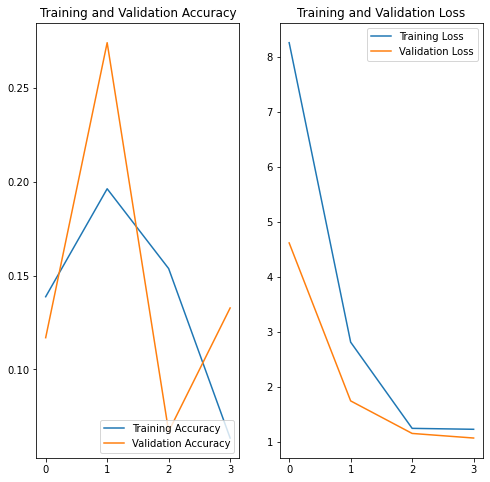

In [21]:
# Get the number of epochs the model ran
number_of_epochs_it_ran = len(history_tc_baseline.history['loss'])

# Extract metrics from the history object
acc = history_tc_baseline.history['accuracy']
val_acc = history_tc_baseline.history['val_accuracy']
loss = history_tc_baseline.history['loss']
val_loss = history_tc_baseline.history['val_loss']

# Create a range of epochs
epochs_range = range(number_of_epochs_it_ran)

# Plot Training and Validation Accuracy and Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the plots
plt.show()


In [22]:
mean_val_acc = sum(val_acc)/len(val_acc)
mean_val_acc

0.14768574573099613

## Model: ImageNet-V2 + Transfer Learning + Data Augmentation + Less Complex with more Dropouts + Regularization

In [6]:
import tensorflow as tf
import tensorflow_addons as tfa
img_height = 224
img_width = 224

image_count = len(df)
val_set_start = int(0.6 * image_count)
test_set_start = int(0.8 * image_count)


emotion_columns = ['agreeableness', 'anger', 'anticipation', 'arrogance',
                  'disagreeableness', 'disgust', 'fear', 'gratitude', 'happiness',
                  'humility', 'love', 'optimism', 'pessimism', 'regret', 'sadness',
                  'shame', 'shyness', 'surprise', 'trust', 'neutral']

# Define augmentation functions
def augment_image(image):
    # Random rotation using rotate with random angle
    angle = tf.random.uniform([], -40 * 3.14159 / 180, 40 * 3.14159 / 180)
    image = tfa.image.rotate(image, angle)  # Using tensorflow_addons
    
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # Random brightness
    image = tf.image.random_brightness(image, 0.2)
    
    # Random contrast
    image = tf.image.random_contrast(image, 0.8, 1.2)
    
    # Random zoom equivalent (using crop and resize)
    crop_size = tf.cast([img_height*0.8, img_width*0.8], tf.int32)
    image = tf.image.random_crop(image, [crop_size[0], crop_size[1], 3])
    image = tf.image.resize(image, [img_height, img_width])
    
    # Ensure the values are still in valid range
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image

def decode_and_augment(path, label, training=True):
    # Read the file
    file_bytes = tf.io.read_file(path)
    # Decode the image
    image = tf.io.decode_image(file_bytes, channels=3, expand_animations=False)
    # Convert to float and resize
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [img_height, img_width])
    # Normalize first
    image = image / 255.0
    
    # Apply augmentation only during training
    if training:
        image = augment_image(image)
    
    return image, label


# Prepare paths and multi-label arrays
train_paths = df['path'][:val_set_start].values
train_labels = df[emotion_columns][:val_set_start].values  # Get all emotion columns

val_paths = df['path'][val_set_start:test_set_start].values
val_labels = df[emotion_columns][val_set_start:test_set_start].values

test_paths = df['path'][test_set_start:].values
test_labels = df[emotion_columns][test_set_start:].values


# Create training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(
    lambda x, y: decode_and_augment(x, y, training=True),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# Create validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(
    lambda x, y: decode_and_augment(x, y, training=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_ds = val_ds.batch(32)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Create test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(
    lambda x, y: decode_and_augment(x, y, training=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.batch(32)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [6]:
# Verify the data format
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Number of emotion classes:", len(emotion_columns))
    print("Sample labels (first image):", labels[0])

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 20)
Number of emotion classes: 20
Sample labels (first image): tf.Tensor([0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int64)


In [7]:
# Define constants
img_height = 224
img_width = 224
batch_size = 32
epochs = 100
L2 = 50
DROP = 0.3

# Define base model
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Freeze base model layers
base_model.trainable = False

# Build the Sequential model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu', 
                         kernel_regularizer=tf.keras.regularizers.l2(L2)),
    tf.keras.layers.Dropout(DROP),
    tf.keras.layers.Dense(200, activation='relu', 
                         kernel_regularizer=tf.keras.regularizers.l2(L2)),
    tf.keras.layers.Dropout(DROP),
    tf.keras.layers.Dense(300, activation='relu', 
                         kernel_regularizer=tf.keras.regularizers.l2(L2)),
    tf.keras.layers.Dropout(DROP),
    tf.keras.layers.Dense(50, activation='relu', 
                         kernel_regularizer=tf.keras.regularizers.l2(L2)),
    tf.keras.layers.Dropout(DROP),
    tf.keras.layers.Dense(50, activation='relu', 
                         kernel_regularizer=tf.keras.regularizers.l2(L2)),
    tf.keras.layers.Dropout(DROP),
    tf.keras.layers.Dense(len(emotion_columns), activation='sigmoid')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.5,
    patience=3,
    verbose=1
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True
)

# Calculate steps per epoch
steps_per_epoch = len(train_paths) // batch_size

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=20,
    callbacks=[es_callback, lr_callback]
)


Epoch 1/100
20/20 [==============================] - 647s 19s/step - loss: 24257.9310 - accuracy: 0.0442 - val_loss: 15638.3447 - val_accuracy: 0.2631
Epoch 2/100
20/20 [==============================] - 412s 22s/step - loss: 13632.1786 - accuracy: 0.1045 - val_loss: 8684.5283 - val_accuracy: 0.3155
Epoch 3/100
20/20 [==============================] - 233s 12s/step - loss: 7580.9924 - accuracy: 0.1604 - val_loss: 4879.3594 - val_accuracy: 0.3155
Epoch 4/100
20/20 [==============================] - 220s 12s/step - loss: 4317.5059 - accuracy: 0.2148 - val_loss: 3038.0786 - val_accuracy: 0.3155


In [12]:
!nvidia-smi

Fri Dec 20 17:28:01 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |  14832MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

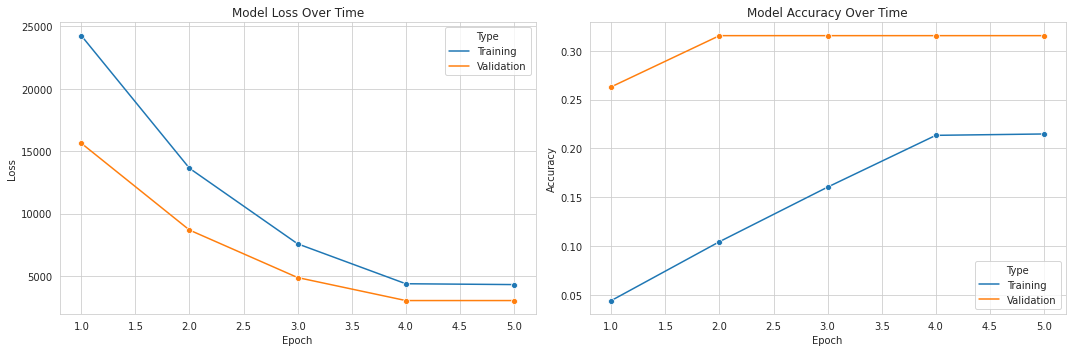

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert history to DataFrame for easier plotting
epochs = range(1, len(history['loss']) + 1)
df_loss = pd.DataFrame({
    'Epoch': list(epochs) + list(epochs),
    'Loss': history['loss'] + history['val_loss'],
    'Type': ['Training']*len(epochs) + ['Validation']*len(epochs)
})

df_acc = pd.DataFrame({
    'Epoch': list(epochs) + list(epochs),
    'Accuracy': history['accuracy'] + history['val_accuracy'],
    'Type': ['Training']*len(epochs) + ['Validation']*len(epochs)
})

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Type', marker='o')
plt.title('Model Loss Over Time')

# Accuracy plot
plt.subplot(1, 2, 2)
sns.lineplot(data=df_acc, x='Epoch', y='Accuracy', hue='Type', marker='o')
plt.title('Model Accuracy Over Time')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [25]:
val_accuracy = model.history['val_accuracy']
mean_val_acc = sum(val_accuracy)/len(val_accuracy)
print(f"Mean Validation Accuracy: {mean_val_acc:.4f}")

TypeError: 'History' object is not subscriptable

In [27]:
mean_val_acc = df_acc[df_acc['Type'] == 'Validation']['Accuracy'].mean()
print(f"Mean Validation Accuracy: {mean_val_acc:.4f}")

Mean Validation Accuracy: 0.3050
